# Predict TripAdvisor Rating
В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor


По ходу задачи:
* Просмотрим данные, которые предоставили
* Сделаем предобработку 
* Поработаем с пропущенными данными (Nan)
* Сгенерируем новые признаки (Feature Engineering) разными способами
* Создадим простую модель для предсказания рейтинга ресторана

*-Всё что написано курсивом - пояснения именно моего процесса работы над этим проектом. Часть кода у меня закомментировано именно для того, что каждый мог самостоятельно проверить некоторые варианты решения поставленной задачи и убедиться, что в конечном результате я использовал данные, которые давали наимеший MEA (т.е действительно проверял разные варианты). Кое где у меня возникли спорные моменты-вопросы-*

# import

In [1]:
# Импортируем необходимые модули
import os
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures  # Для полиномиальных признаков
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from textblob import TextBlob  # Для определения тональности отзывов
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Настройки для более комфортного отображения таблиц
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 50)

# Просмотр файлов в директории
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# Фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

# Вспомогательные функции

In [4]:
def creatre_columns_NAN(data, list_columns):
    """На вход подаётся список колонок и ДФ, для которых создаются новые колонки с нулями и единицами,
    где 1 - в месте пропуска"""
    data_Nan = pd.DataFrame()
    for i in list_columns:
        data_Nan[i+'_is_NAN'] = pd.isna(data[i]).astype('uint8')
    return data_Nan

# Данные

Открываем файлы, смотрим что из себя представляют

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
3758,id_2821,Rome,"['Italian', 'Mediterranean']",2822.0,4.0,$,150.0,"[['Very surprised', 'Great selection, Fresh and good service'], ['08/23/2016', '06/26/2016']]",/Restaurant_Review-g187791-d3528375-Reviews-Mondo_Arancina-Rome_Lazio.html,d3528375
36377,id_482,Prague,"['American', 'Bar', 'European', 'Vegetarian Friendly']",483.0,4.0,$$ - $$$,93.0,"[['Just the job!', 'Cool, open, relaxed'], ['01/04/2018', '11/10/2017']]",/Restaurant_Review-g274707-d10536211-Reviews-Blackdog_Cantina-Prague_Bohemia.html,d10536211
19338,id_671,Milan,"['Lebanese', 'Mediterranean', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']",673.0,4.0,$$ - $$$,134.0,"[['Nice ladies’ night out', 'Lunch with friends'], ['01/06/2018', '04/10/2017']]",/Restaurant_Review-g187849-d12059326-Reviews-Ristorante_Fairouz-Milan_Lombardy.html,d12059326


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
5729,id_5729,Prague,['Asian'],3636.0,NaN,4.0,"[['Dont bother!', 'Great discover'], ['10/10/2017', '05/02/2016']]",/Restaurant_Review-g274707-d7123906-Reviews-Yuan_Zhong_Yuan-Prague_Bohemia.html,d7123906
9112,id_9112,Madrid,NaN,8290.0,NaN,87.0,"[['Good food and atmosphere', 'horrible'], ['12/15/2017', '08/29/2016']]",/Restaurant_Review-g187514-d7254620-Reviews-La_Divina_de_Castellana-Madrid.html,d7254620
2544,id_2544,Paris,NaN,12898.0,NaN,28.0,"[['Good atmosphere', 'Looks cosy but be careful!'], ['10/02/2017', '11/14/2016']]",/Restaurant_Review-g187147-d10792252-Reviews-Le_Chantier_Interdit-Paris_Ile_de_France.html,d10792252


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [14]:
data.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
20731,id_480,Oslo,NaN,481.0,NaN,11.0,"[['Good neighborhood wine bar', 'Oslos best winebar!'], ['02/13/2017', '11/29/2016']]",/Restaurant_Review-g190479-d8591199-Reviews-Barotto_AS-Oslo_Eastern_Norway.html,d8591199,1,4.5
46540,id_2316,Prague,NaN,2321.0,NaN,6.0,"[['Great food', 'Decent lunch for moderate price'], ['03/06/2017', '03/14/2015']]",/Restaurant_Review-g274707-d4768017-Reviews-Amarilis_Energia-Prague_Bohemia.html,d4768017,1,4.0
18089,id_15879,London,['Chinese'],15891.0,$,8.0,"[['English style chinese takeaway', 'Good food but terrible customer service'], ['10/23/2017', '10/08/2016']]",/Restaurant_Review-g186338-d5122276-Reviews-Hua_Xin-London_England.html,d5122276,1,2.0


Большинство признаков у нас требует очистки и предварительной обработки.

# Обработка

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
Поэтому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


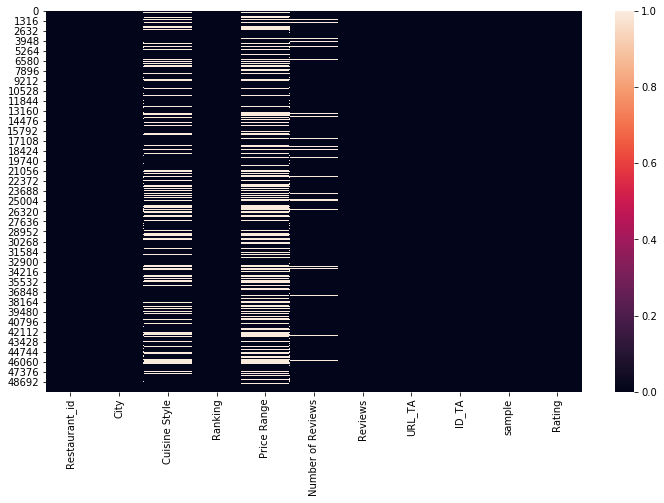

In [16]:
# "Матрица" с пропусками для примерной наглядной оценки
ax = plt.subplots(figsize=(12, 7))
ax = sns.heatmap(data.isnull())

In [17]:
# Cоздаём список колонок, для которых сделаем другие колонки, отмечающие места пропусков
list_columns_with_Nan = ['Number of Reviews',
                         'Cuisine Style', 'Price Range', 'Reviews']

# Сохраним их в отдельный ДФ, который присоединим к data перед моделированием
columns_NAN = creatre_columns_NAN(data, list_columns_with_Nan)
columns_NAN

,Number of Reviews_is_NAN,Cuisine Style_is_NAN,Price Range_is_NAN,Reviews_is_NAN
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
49995,0,0,0,0
49996,0,0,0,0
49997,0,0,1,0
49998,0,0,0,0


Обрабатывать пропуски будем "индивидуально" для каждого столбца. 
Сейчас рассмотрим столбцы. 

Колонки Restaurant_id, URL_TA и ID_TA не информативны, поэтому можно сразу удалить эти столбцы

In [18]:
data.drop(['Restaurant_id', 'URL_TA'], axis = 1, inplace=True)  #'ID_TA'

# City

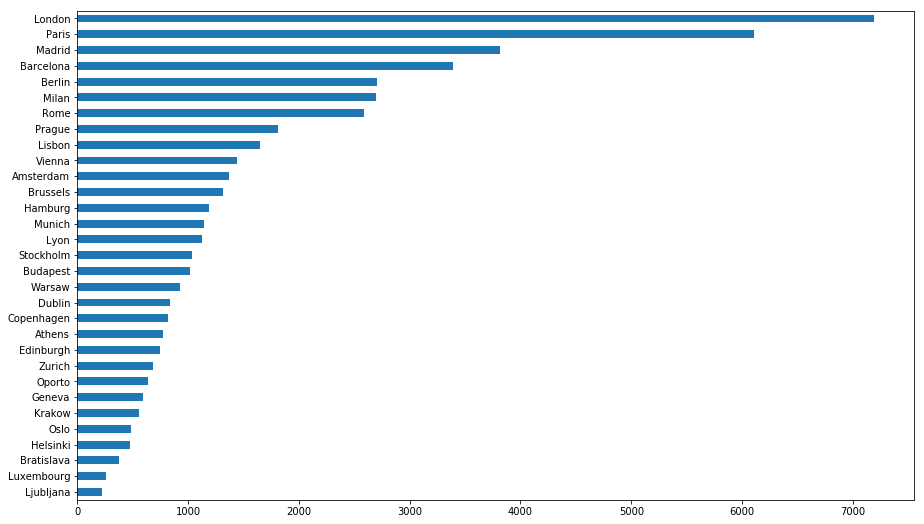

In [19]:
data.City.value_counts(ascending=True).plot(kind='barh', figsize=(15,9))

Всего 31 город. В дальнейшем добавим данные по населению и площади этих городов. Сгруппируем данные по городам, для дальнейшей обработки пропусков

*-Можно создать список столиц и сделать колонку, где 1 - если город является столицей, но у меня это в последующем не улучшило модель-*

In [20]:
#capital_city = ['Amsterdam', 'Athens', 'Berlin', 'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', 'Dublin', 'Helsinki', 'Lisbon',
#         'Ljubljana', 'London', 'Luxembourg', 'Madrid', 'Oslo', 'Paris', 'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw'] 
#data['Capital'] = data['City'].apply(lambda x: 1 if x in capital_city else 0)

In [21]:
# Создадим таблицы по городам со средними, max и median значениями для дальнейшей замены пропусков
data_city_mean = data.groupby('City').mean().round()
data_city_max = data.groupby('City').max()
data_city_median = data.groupby('City').median()
data_city_mean

,Ranking,Number of Reviews,sample,Rating
City,,,,
Amsterdam,1592.0,149.0,1.0,3.0
Athens,880.0,94.0,1.0,3.0
Barcelona,3879.0,136.0,1.0,3.0
Berlin,3255.0,64.0,1.0,3.0
Bratislava,462.0,52.0,1.0,3.0
Brussels,1542.0,93.0,1.0,3.0
Budapest,1219.0,159.0,1.0,3.0
Copenhagen,982.0,95.0,1.0,3.0
Dublin,972.0,154.0,1.0,3.0


*-Уменьшал окончательный список городов, чтобы не добавлять 31 колонку как dummy-признаки (брал топ-10 город, а остальные писал в "другие", брал города в которых ресторанов большее 1000), но окончательная модель была хуже-*

# Cuisine Style

Посчитаем количество кухонь в каждом ресторане. Если нет данных, то предположим, что только один вид

In [22]:
data['Cuisine Style'].fillna('[]', inplace = True)
data['Cuisine Style'] = data['Cuisine Style'].apply(
    lambda x:str(x).replace('[','').replace(']','').replace("'", '').replace(' ','').replace('"',''))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.split(','))
data['Number of kitchen'] = data['Cuisine Style'].apply(lambda x: len(x))

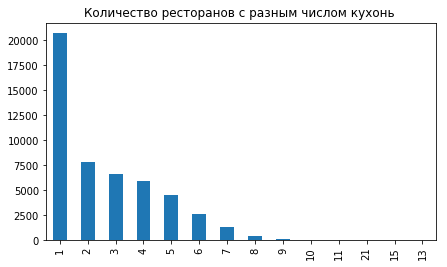

In [23]:
data['Number of kitchen'].value_counts().plot(kind='bar', figsize=(7,4),
                                              title='Количество ресторанов с разным числом кухонь ')

# Price Range

In [24]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Заменим значения на 1, 2 или 3 соотвественно. Посмотрим на средние цены по городам

In [25]:
data['Price Range'] = data['Price Range'].apply(
    lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3 if x == '$$$$' else x)

In [26]:
data.groupby('City').mean()['Price Range']

City
Amsterdam     1.832700
Athens        1.706767
Barcelona     1.783784
Berlin        1.743094
Bratislava    1.863636
Brussels      1.858974
Budapest      1.718169
Copenhagen    1.900369
Dublin        1.788644
Edinburgh     1.710000
Geneva        2.049751
Hamburg       1.864762
Helsinki      1.867508
Krakow        1.652520
Lisbon        1.729954
Ljubljana     1.746835
London        1.808891
Luxembourg    1.978836
Lyon          1.896147
Madrid        1.849199
Milan         1.743210
Munich        1.911846
Oporto        1.668934
Oslo          1.940120
Paris         1.891774
Prague        1.740376
Rome          1.734466
Stockholm     1.942238
Vienna        1.857968
Warsaw        1.813167
Zurich        1.972458
Name: Price Range, dtype: float64

Средние цены близки по городам к средним (2), поэтому заменим пропуски именно на это число

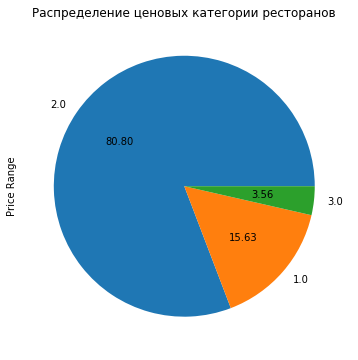

In [27]:
data['Price Range'].fillna(2, inplace=True)
data['Price Range'].value_counts().plot(kind='pie', autopct="%.2f",
                                        title='Распределение ценовых категории ресторанов',
                                        figsize=(6,6))

# Ranking

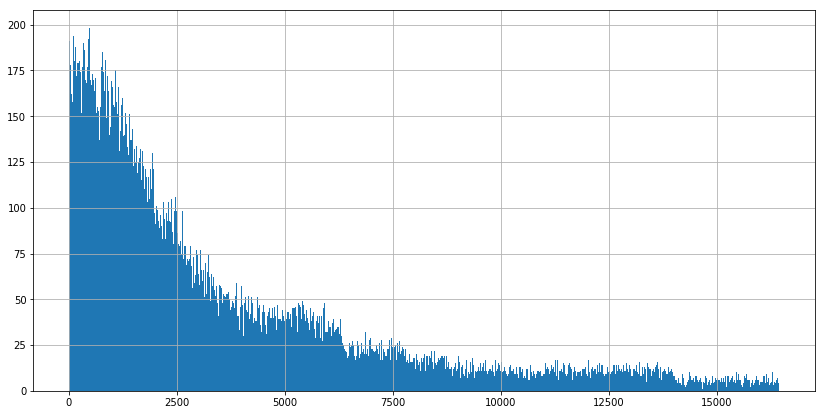

In [28]:
df_train['Ranking'].hist(bins=1000, figsize=(14,7))

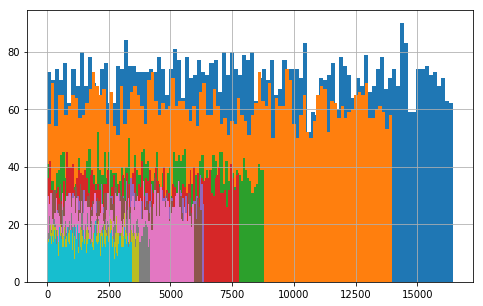

In [29]:
# посмотрим на данные по Ranking топ 10-ти городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100, figsize=(8,5))

В больших городах больше ресторанов, значит Ranking у некоторых может быть очень высокий. 
Нужно нормировать значения по городам, чтобы при обучении модели не было ошибок. 

In [30]:
# Создаём колонку с нормированным по городам рангом ресторанов
data['Ranking_NORM'] = data[['City', 'Ranking']].apply(
    lambda x:x[1]/data_city_max.Ranking[x[0]], axis=1)

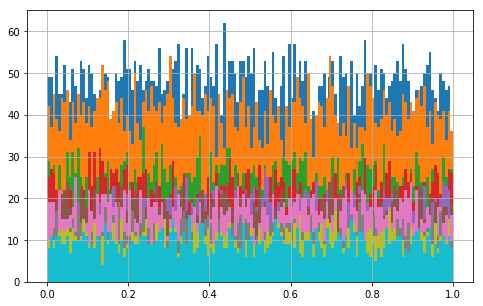

In [31]:
for x in (df_train['City'].value_counts())[0:10].index:
    data['Ranking_NORM'][data['City'] == x].hist(bins=150, figsize=(8,5))

# Number of Reviews

Пропуски в колонке число отзывов заменим на среднее количество отзывов в городе

In [32]:
# Заменим на среднее количество отзывов в городе
data['Number of Reviews'] = data[['City', 'Number of Reviews']].apply(
    lambda x: data_city_mean['Number of Reviews'].to_dict()[x[0]] if pd.isna(x[1]) else x[1], axis=1)

In [33]:
# Проверим, что нет отрицательного количества отзывов
(data['Number of Reviews'].value_counts()<0).sum()

0

# Reviews

Наиболее сложная колонка для обработки. Пропуски заполним '[[], []]'

Данные представлены типом str, необходимо разделить на две части - сами отзывы и даты. Эти части нужно в свою очередь разделить ещё на две части, чтобы получилось два столбца с самим текстом отзывов и два столбца с датами этих отзывов. Оставим пустые отзывы, если их нет. В дальнейшем сделаем тональный анализ. 

Из колонок с датами вытащим информацию о днях недели, месяце, разнице в днях между отзывами, а так же как давно были написаны отзывы. Все эти действия завернём в функцию, для более комфортного использования далее

In [34]:
def change_reviews(data, df_columns):
    """ Функция принимает на вход ДФ (чтобы можно завернуть эту функцию в другую) и колонку с отзывами.
    Создаёт новые колонки"""
    df_columns.fillna('[[], []]', inplace=True)
    data['Two_reviews'] = df_columns.apply(lambda x: x.split('],')[0].split("',"))
    # Создаёт две колонки с текстами отзывов
    data['Review_1'] = data['Two_reviews'].apply(lambda x: x[0])
    data['Review_2'] = data['Two_reviews'].apply(lambda x: x[-1])
    data['Review_1'] = data['Review_1'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace('"', ''))
    data['Review_2'] = data['Review_2'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace('"', ''))
    data.drop('Two_reviews', axis=1, inplace=True)

    # Удалим повторы, если отзыв был один и он продублировался в столбец Review_2
    data['Review_2'] = data[['Review_2', 'Review_1']].apply(
        lambda x: '' if x[0] == x[1] else x[0], axis=1)

    # Работа с датами
    data['Days_reviews'] = df_columns.apply(
        lambda x: x.split('],')[-1].split("',"))
    data['Day_1'] = data['Days_reviews'].apply(lambda x: x[0])
    data['Day_2'] = data['Days_reviews'].apply(lambda x: x[-1])
    data['Day_1'] = data['Day_1'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace(']', '').replace(' ', '').replace('"', ''))
    data['Day_2'] = data['Day_2'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace(']', '').replace(' ', '').replace('"', ''))
    data.drop('Days_reviews', axis=1, inplace=True)

    # Удалим вторую дату (дубликат первой), если отзыв был всего один
    data['Day_2'] = data[['Day_2', 'Review_2']].apply(
        lambda x: '' if x[1] == '' else x[0], axis=1)

    # Переведём данные в формат datetime.strptime для удобства дальнейшей работы
    data['Day_1'] = data['Day_1'].apply(lambda x: x if len(
        x) == 0 else datetime.strptime(x, '%m/%d/%Y'))
    data['Day_2'] = data['Day_2'].apply(lambda x: x if len(
        x) == 0 else datetime.strptime(x, '%m/%d/%Y'))

    # Cоздаём колонки, показывающие сколько дней назад были написаны отзывы
    data['How_long_ago_1'] = (datetime.today() - data['Day_1'])
    data['How_long_ago_2'] = datetime.today() - data['Day_2']
    data['How_long_ago_1'] = data['How_long_ago_1'].apply(lambda x: x.days)
    data['How_long_ago_2'] = data['How_long_ago_2'].apply(lambda x: x.days)
    # Если пропущены значения, то заменим на среднее
    data['How_long_ago_1'].fillna(
        round(data['How_long_ago_1'].mean()), inplace=True)
    data['How_long_ago_2'].fillna(
        round(data['How_long_ago_2'].mean()), inplace=True)

    # Создаём колонку с разницей в датах отзывов
    data['Day1_2'] = abs(data['Day_1'] - data['Day_2'])
    data['Day_1'] = data['Day_1'].fillna(0)
    data['Day_2'] = data['Day_2'].fillna(0)
    data['Day1_2'] = data['Day1_2'].apply(lambda x: x.days)
    data['Day1_2'] = data['Day1_2'].fillna(0)

    # Создаём колонки с днями недели отзывов и месяцы
    data['Day_of_week_1'] = data['Day_1'].apply(
        lambda x: 0 if x == 0 else x.strftime('%A'))
    data['Day_of_week_2'] = data['Day_2'].apply(
        lambda x: 0 if x == 0 else x.strftime('%A'))
    data['Month_1'] = data['Day_1'].apply(
        lambda x: 0 if x == 0 else x.strftime('%m'))
    data['Month_2'] = data['Day_2'].apply(
        lambda x: 0 if x == 0 else x.strftime('%m'))

    # Удаляем больше ненужные колонки
    data.drop('Day_1', axis=1, inplace=True)
    data.drop('Day_2', axis=1, inplace=True)
    data.drop('Reviews', axis=1, inplace=True)

*-В Baseline было предложено в конце всю работу завернуть в одну большую функцию для удобства и воспроизводимости кода. У меня возникли сложности с включением в неё вышенаписанную функцию, поэтому на данный момент я отказался от создания такой большой общей функции для воспроизведения. Доразберусь с пространством имен в работе с функциями - улучшу финальную часть-*

In [35]:
change_reviews(data, data['Reviews'])

In [36]:
data.sample(3)

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number of kitchen,Ranking_NORM,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,Day_of_week_1,Day_of_week_2,Month_1,Month_2
20182,Paris,"[French, European, WineBar, Spanish]",1882.0,2.0,103.0,d8630212,1,4.5,4,0.134563,A charming little gem in the heart of Mont...,Awsome burger!,1569.0,1583.0,14.0,Thursday,Thursday,12,11
37338,Madrid,[],5132.0,2.0,4.0,d12216416,1,4.0,1,0.582586,,,1422.0,1490.0,0.0,0,0,0,0
33034,London,"[American, British]",10082.0,2.0,35.0,d8655414,1,4.0,2,0.613111,Tucked away pub,Awesome Place for Private Function & Great...,1194.0,1373.0,179.0,Monday,Thursday,12,06


Внимательнее изучим данные по датам (дням, просшедним после написания отзывов)

In [37]:
data['How_long_ago_1'].value_counts()

1422.0    8156
1174.0     607
1178.0     534
1175.0     498
1177.0     461
          ... 
2542.0       1
3549.0       1
2826.0       1
3345.0       1
2854.0       1
Name: How_long_ago_1, Length: 1976, dtype: int64

Text(0, 0.5, 'Прошло дней от публикации отзывов')

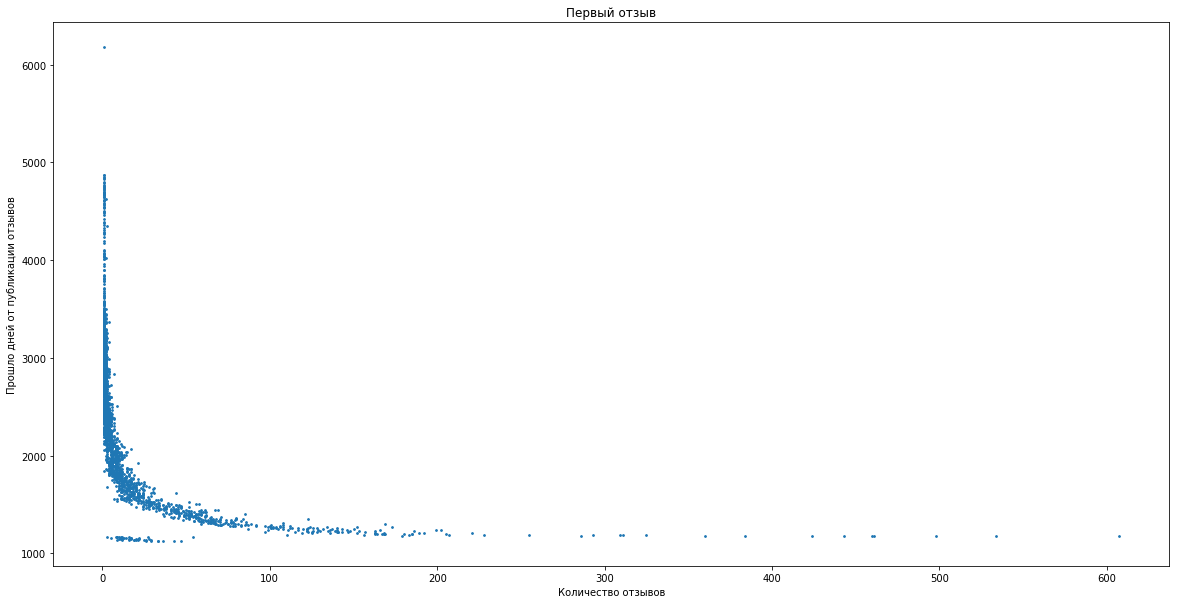

In [38]:
# Посмотроим график, где по оси y - прошедшие дни от отзыва, а по x - количество отзывов в эти дни.
# А день, когда было опубликовано наибольшее количество отзывов не будет показывать
fig, ax = plt.subplots()
x = data['How_long_ago_1'].value_counts().iloc[1:]
y = data['How_long_ago_1'].value_counts().iloc[1:].index
fig.set_figwidth(20)
fig.set_figheight(10)
ax.scatter(x, y, s = 3)
ax.set_title('Первый отзыв')
ax.set_xlabel('Количество отзывов')
ax.set_ylabel('Прошло дней от публикации отзывов')

Один день очень сильно выбивается из общей картины. Возможно ошибка в данных, и отзыв был опубликован не почти 17 лет назад. Заменим на среднее значение в столбце, а день недели на 0.

In [39]:
data[data['How_long_ago_1'] == data['How_long_ago_1'].max()]

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number of kitchen,Ranking_NORM,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,Day_of_week_1,Day_of_week_2,Month_1,Month_2
47913,Vienna,"[Bar, Pub]",3137.0,1.0,2.0,d694328,1,4.0,2,0.910859,Great affordable restaurant,,6183.0,1490.0,0.0,Wednesday,0,04,0


In [40]:
data.at[47913, 'How_long_ago_1'] = data['How_long_ago_1'].mean()
data.at[47913, 'Day_of_week_1'] = 0

*-Без этих замен в данных MAE было меньше, т.е. этим действием по корректировки данных (?) я ухудшил модель-*

Text(0, 0.5, 'Прошло дней от публикации отзывов')

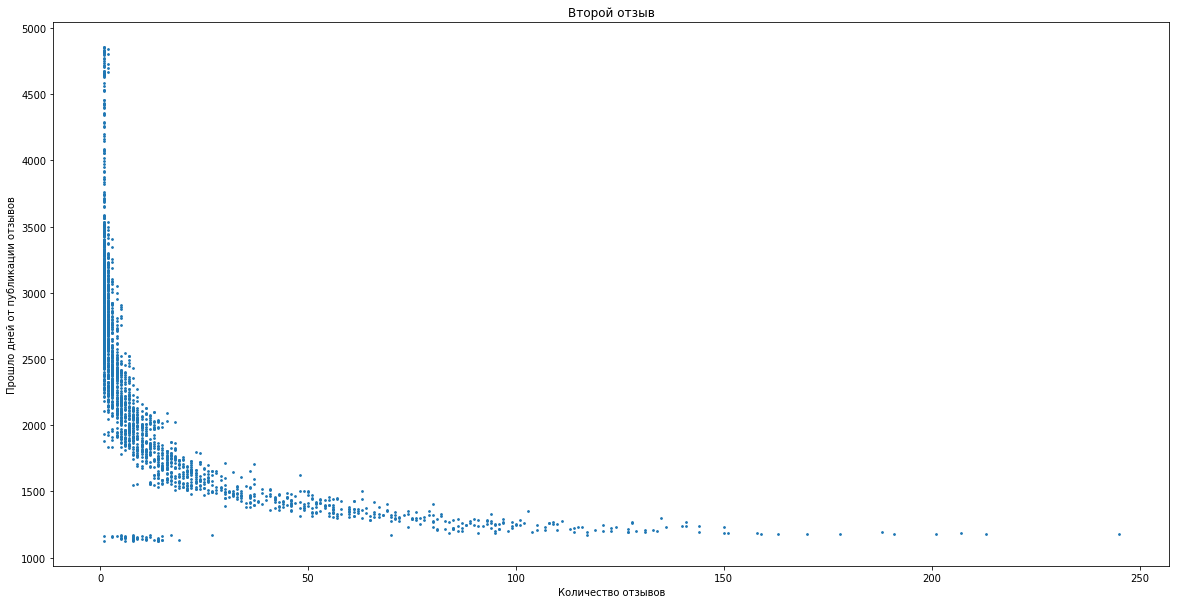

In [41]:
fig, ax = plt.subplots()
x = data['How_long_ago_2'].value_counts().iloc[1:]
y = data['How_long_ago_2'].value_counts().iloc[1:].index
fig.set_figwidth(20)
fig.set_figheight(10)
ax.scatter(x, y, s = 3)
ax.set_title('Второй отзыв')
ax.set_xlabel('Количество отзывов')
ax.set_ylabel('Прошло дней от публикации отзывов')

Явных выбросов не наблюдается

# Тональный анализ

Для тонального анализа текста использую простую библиотеку TextBlob. В основе её работы используется база данных по ключевым словам по отзывам к фильмам. Библиотека анализирует текст и возвращается число в промежутке от -1 до 1, обозначающее тональную окраску (-1 для негативной, 0 для нейтральной и 1 для полностью позитивной.

*-Пытался добавить свои слова в базу данных этой библиотеки, связанные именно с едой (вкусно, деликатес и т.д.), но почему-то пока не вышло. Обязательно ещё вернусь к этому вопросу-*

In [42]:
data['Review_1'] = data['Review_1'].apply(lambda x: TextBlob(x).polarity)
data['Review_2'] = data['Review_2'].apply(lambda x: TextBlob(x).polarity)

*-Отзывы равнозначные, поэтому можно сделать одну колонку с тональностью отзывов, но у меня это не улучшило модель (хотя по логике так правильнее поступить ведь(?))-*

In [43]:
#data['Review'] = data['Review_1'] + data['Review_2']
#data.drop('Review_1', axis=1, inplace=True)
#data.drop('Review_2', axis=1, inplace=True)

In [44]:
data.sample(3)

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number of kitchen,Ranking_NORM,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,Day_of_week_1,Day_of_week_2,Month_1,Month_2
25562,Milan,[Barbecue],4938.0,2.0,11.0,d6701582,1,3.5,1,0.786932,0.000000,0.0,1422.0,1490.0,0.0,0,0,0,0
3860,Barcelona,[Mediterranean],7783.0,2.0,136.0,d12408044,0,0.0,1,0.998332,0.000000,0.0,1422.0,1490.0,0.0,0,0,0,0
3486,Dublin,[],1272.0,2.0,3.0,d10205490,0,0.0,1,0.648980,-0.260417,1.0,1787.0,1787.0,0.0,Wednesday,Wednesday,05,05


# Самое последнее

In [45]:
data['ID_TA'] = data['ID_TA'].apply(lambda x:x[1:])

In [46]:
# Создам словарь с городами и их площадью (в кв. км)
city_square = {'Paris': 105.4, 'Stockholm': 188, 'London': 1572, 'Berlin': 891.68, 'Munich': 310.71, 'Oporto': 41.66,
               'Milan': 181.67, 'Bratislava': 368, 'Vienna': 414.75, 'Rome': 1287.36, 'Barcelona': 101.3, 'Madrid': 607,
               'Dublin': 318, 'Brussels': 32.61, 'Zurich': 91.88, 'Warsaw': 517, 'Budapest': 525.14, 'Copenhagen': 86.40,
               'Amsterdam': 219.4, 'Lyon': 47.87, 'Hamburg': 755.09, 'Lisbon': 100.05, 'Prague': 500, 'Oslo': 454,
               'Helsinki': 213.8, 'Edinburgh': 118, 'Geneva': 15.93, 'Ljubljana': 163.8, 'Athens': 412,
               'Luxembourg': 51.47, 'Krakow': 327}
data['Сity square'] = data['City'].apply(lambda x: city_square[x])

In [47]:
# Создам словарь с городами и населением в них (в тыс. человек)
population_in_the_сity = {'Paris': 2148, 'Stockholm': 961, 'London': 8908, 'Berlin': 3644, 'Munich': 1471, 'Oporto': 237,
                          'Milan': 1378, 'Bratislava': 437, 'Vienna': 1897, 'Rome': 2870, 'Barcelona': 1664, 'Madrid': 3266,
                          'Dublin': 1173, 'Brussels': 179, 'Zurich': 428, 'Warsaw': 1790, 'Budapest': 1752, 'Copenhagen': 615,
                          'Amsterdam': 872, 'Lyon': 506, 'Hamburg': 1841, 'Lisbon': 505, 'Prague': 1301, 'Oslo': 673,
                          'Helsinki': 655, 'Edinburgh': 488, 'Geneva': 200, 'Ljubljana': 284, 'Athens': 664,
                          'Luxembourg': 115, 'Krakow': 779}
data['Population'] = data['City'].apply(lambda x: population_in_the_сity[x])

In [48]:
# Столбец - отношение относительного ранга к населению
data['Rank/Population'] = data['Ranking_NORM'] / data['Population']

In [49]:
# Создадим колонку, показывающую на сколько человек в городе приходится один отзыв 
data['Population/Number of Reviews'] = data['Population'] / data['Number of Reviews']

In [50]:
dummy_city = pd.get_dummies(data.City) # Создадим dummy-признаки городов
data = pd.concat([data, dummy_city], axis=1)

In [51]:
#dummy_price = pd.get_dummies(data['Price Range'])  # Делаем дамми-признаки цен
#data = pd.concat([data, dummy_price], axis=1)  # Добавляем в данные

In [52]:
dummy_day_1 = pd.get_dummies(data['Day_of_week_1'])  # Делаем дамми-признаки дней недели для отзывов
dummy_day_2 = pd.get_dummies(data['Day_of_week_2'])
dummy_day = dummy_day_1 + dummy_day_2
data = pd.concat([data, dummy_day], axis=1).drop([0], axis = 1)

In [53]:
# Делаем дамми-признаки месяцев отзывал и объединяем их в сезоны года
dummy_season_1 = pd.get_dummies(data['Month_1'])
dummy_season_2 = pd.get_dummies(data['Month_2'])
dummy_season = dummy_season_1 + dummy_season_2
data['Winter_reviews'] =  dummy_season['12'] + dummy_season['01'] + dummy_season['02']
data['Spring_reviews'] =  dummy_season['03'] + dummy_season['04'] + dummy_season['05']
data['Summer_reviews'] =  dummy_season['06'] + dummy_season['07'] + dummy_season['08']
data['Autumn_reviews'] =  dummy_season['09'] + dummy_season['10'] + dummy_season['11']

In [54]:
# Добавим колонки с пропусками
data = pd.concat([data, columns_NAN], axis=1)

In [55]:
# Добавим колонки с полиноальными признаками площади и населения города
pf = PolynomialFeatures(2)
poly_city = pf.fit_transform(data[['Сity square', 'Population']])
poly_city = pd.DataFrame(poly_city, columns=[
                         '1', 'Сity square', 'Population', 'Сity square^2', 'Сity square_Population', 'Population^2'])
# Удалим дубликаты и ненужный столбец "1"
poly_city.drop(['Сity square', '1', 'Population'], axis=1, inplace=True)
data = pd.concat([data, poly_city], axis=1)

In [56]:
# Добавить колонки с полиноальными признаками тональности отзывов
# pf_review = PolynomialFeatures(2)
# poly_review = pf_review.fit_transform(data[['Review_1', 'Review_2']])
# poly_review = pd.DataFrame(poly_review, columns = ['1','Review_1','Review_2', 'Review_1^2', 
#                                                      'Review_1Review_2', 'Review_2^2'])
# poly_review.drop(['Review_1', '1', 'Review_2'], axis = 1, inplace=True) # Удалим дубликаты и ненужный столбец 1
# data = pd.concat([data, poly_review], axis=1)

In [57]:
data.sample(3)

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number of kitchen,Ranking_NORM,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,Day_of_week_1,Day_of_week_2,Month_1,Month_2,Сity square,Population,Rank/Population,Population/Number of Reviews,Amsterdam,Athens,...,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Winter_reviews,Spring_reviews,Summer_reviews,Autumn_reviews,Number of Reviews_is_NAN,Cuisine Style_is_NAN,Price Range_is_NAN,Reviews_is_NAN,Сity square^2,Сity square_Population,Population^2
22983,Hamburg,[],475.0,2.0,31.0,718286,1,4.5,1,0.173548,0.044444,1.0,1317.0,2159.0,842.0,Thursday,Tuesday,08,04,755.09,1841,0.000094,59.387097,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,5.701609e+05,1390120.69,3389281.0
4052,Bratislava,[Cafe],391.0,1.0,52.0,12977600,0,0.0,1,0.439820,0.712500,0.0,1261.0,1490.0,0.0,Thursday,0,10,0,368.00,437,0.001006,8.403846,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1.354240e+05,160816.00,190969.0
16877,London,"[Italian, Mediterranean, European, VegetarianFriendly, VeganOptions, GlutenFreeOptions]",171.0,2.0,859.0,718583,1,4.5,6,0.010399,0.800000,0.0,1177.0,1184.0,7.0,Thursday,Thursday,01,12,1572.00,8908,0.000001,10.370198,0,0,...,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,2.471184e+06,14003376.00,79352464.0


In [58]:
# Удалим ненужные столбцы (тут я экспериментировал, чтобы получить меньше значение MEA)
data = data.drop(['City', 'Cuisine Style', 'Ranking', 'Day_of_week_1', 'Day_of_week_2',
                  'Month_1', 'Month_2', 'Сity square', 'Population', 'Reviews_is_NAN'], axis = 1)

In [59]:
data.sample(5)

,Price Range,Number of Reviews,ID_TA,sample,Rating,Number of kitchen,Ranking_NORM,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,Rank/Population,Population/Number of Reviews,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,...,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Winter_reviews,Spring_reviews,Summer_reviews,Autumn_reviews,Number of Reviews_is_NAN,Cuisine Style_is_NAN,Price Range_is_NAN,Сity square^2,Сity square_Population,Population^2
5624,2.0,114.0,3326627,0,0.0,5,0.263026,0.700000,0.25,1529.0,1536.0,7.0,0.000072,31.964912,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,7.950932e+05,3249281.92,13278736.0
7477,2.0,327.0,2330375,0,0.0,6,0.112419,-0.500000,1.00,1222.0,1250.0,28.0,0.000117,2.938838,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,3.534400e+04,180668.00,923521.0
27034,2.0,43.0,12450637,1,3.5,2,0.724937,0.316667,0.00,1172.0,1177.0,5.0,0.000493,34.209302,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,0,0,0,0,0,9.654070e+04,457054.41,2163841.0
12632,2.0,2.0,2454351,1,3.5,1,0.810677,0.000000,0.00,1422.0,1490.0,0.0,0.000588,689.000000,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.300399e+04,250341.26,1898884.0
44679,2.0,605.0,1014297,1,3.5,6,0.231817,0.000000,0.60,1186.0,1191.0,5.0,0.000026,14.723967,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,0,0,0,0,0,2.471184e+06,14003376.00,79352464.0


> ### Самое наглядное - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже можно заметить, как признаки связаны между собой и с целевой переменной.

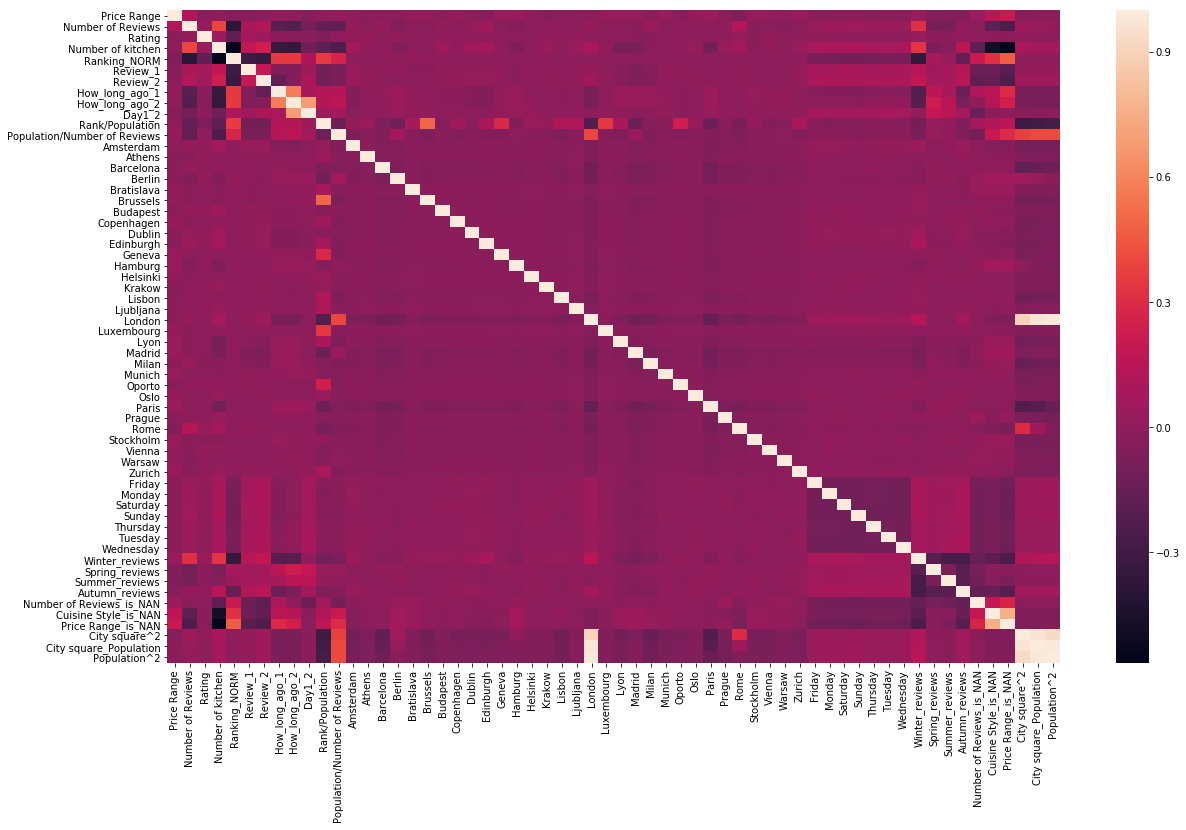

In [60]:
plt.rcParams['figure.figsize'] = (20,12)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Нельзя выделить признаки, которые явно связаны с целевой переменной Rating. Поэтому все признаки будут использованы при моделировании.

In [61]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [62]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [63]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 61), (40000, 61), (40000, 60), (32000, 60), (8000, 60))

In [64]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [65]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [66]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [67]:
# Округлим до 0.5 полученные значения рейтинга
y_pred = (y_pred*2).round()/2
y_pred

array([4.5, 5. , 4.5, ..., 4.5, 4. , 4. ])

In [68]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1620625


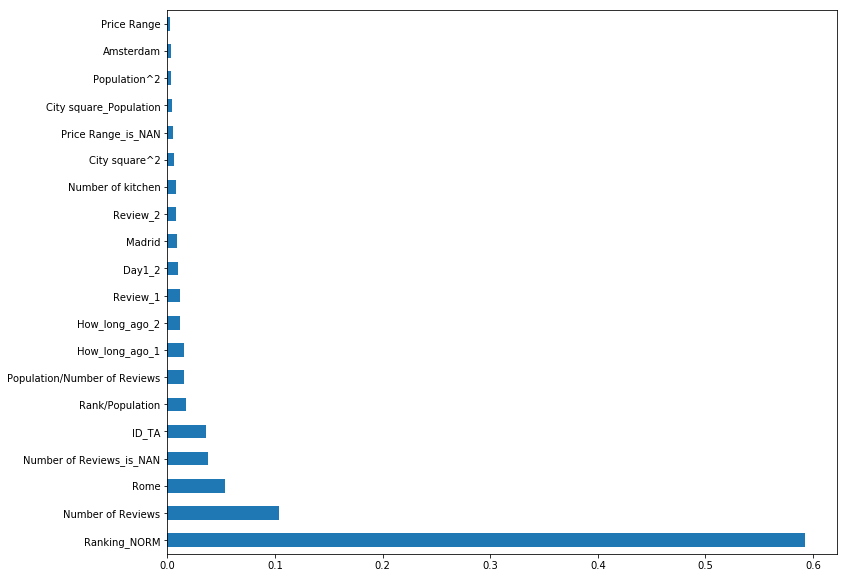

In [69]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (12,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission
Все устраевает - готовим Submission на кагл

In [70]:
test_data.sample(10)

,Price Range,Number of Reviews,ID_TA,Rating,Number of kitchen,Ranking_NORM,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,Rank/Population,Population/Number of Reviews,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,...,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Winter_reviews,Spring_reviews,Summer_reviews,Autumn_reviews,Number of Reviews_is_NAN,Cuisine Style_is_NAN,Price Range_is_NAN,Сity square^2,Сity square_Population,Population^2
3413,2.0,33.0,8432690,0.0,3,0.907762,-0.166667,0.00000,1320.0,1332.0,12.0,0.002077,13.242424,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2,0,0,0,0,1.354240e+05,160816.00,190969.0
2379,2.0,73.0,8733614,0.0,1,0.809494,1.000000,0.00000,1986.0,1490.0,0.0,0.001891,5.863014,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,8.441934e+03,39324.64,183184.0
8484,2.0,80.0,4129260,0.0,3,0.483337,0.800000,-0.10000,1209.0,1265.0,56.0,0.000054,111.350000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,1,0,0,0,2.471184e+06,14003376.00,79352464.0
3798,2.0,418.0,6417784,0.0,6,0.162447,0.725000,-0.39375,1248.0,1296.0,48.0,0.000050,7.813397,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,0,0,3.684490e+05,1982462.00,10666756.0
9416,2.0,71.0,753109,0.0,2,0.278427,0.200000,0.00000,1190.0,1233.0,43.0,0.000319,12.281690,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,4.813636e+04,191316.80,760384.0
9423,2.0,37.0,4290252,0.0,4,0.322610,0.256250,0.80000,1320.0,1454.0,134.0,0.000036,240.756757,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,2.471184e+06,14003376.00,79352464.0
4874,2.0,284.0,987957,0.0,2,0.073221,0.000000,0.35000,1439.0,1518.0,79.0,0.000022,11.500000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,3.684490e+05,1982462.00,10666756.0
7574,2.0,33.0,3170014,0.0,2,0.344947,0.000000,0.20000,1523.0,1336.0,187.0,0.000095,110.424242,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,7.950932e+05,3249281.92,13278736.0
5193,2.0,41.0,9763370,0.0,3,0.526546,-0.250000,1.00000,1353.0,1383.0,30.0,0.001230,10.439024,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,2,0,0,0,0,8.441934e+03,39324.64,183184.0
6191,2.0,128.0,12790648,0.0,2,0.789077,0.600000,0.00000,1321.0,1490.0,0.0,0.001563,3.945312,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1.001000e+04,50525.25,255025.0


In [71]:
test_data = test_data.drop(['Rating'], axis=1)

In [72]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [73]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [74]:
predict_submission

array([3.16 , 4.26 , 4.215, ..., 3.035, 4.47 , 4.285])

In [75]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.160
1,id_1,4.260
2,id_2,4.215
3,id_3,4.300
4,id_4,4.480
5,id_5,4.485
6,id_6,1.595
7,id_7,3.450
8,id_8,4.125
9,id_9,4.650
